-----
## Dataset Management Utilities

This file creates the load_and_preprocess_data.py file, then imports it and runs some tests on the methods to confirm they are working as expected.

In [1]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/alan/projects/venv-jupyter/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%%writefile load_and_preprocess_data.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.model_selection import KFold


class TrainDataInfo:
    def __init__(self, train_folder, kfold_splits=5):
        '''
        Given a folder, index all images there and various statistics about them
        '''
        if not os.path.isdir(train_folder):
            raise NotADirectoryError(f'Folder "{train_folder}" does not exist')
        
        # This is a list of all the members we're going to have at the end of __init__
        self.filename_map = None
        self.country_names = None
        self.country_counts = None
        self.sampling_probs = None
        self.weight_scalars = None
        self.traintest_splits = []
        
        self.filename_map = defaultdict(lambda: list())
        for root,subs,files in os.walk(train_folder):
            country = os.path.split(root.lstrip('./').rstrip('/'))[-1]
            if len(country.strip()) == 0:
                continue

            for f in files:
                if not os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                    continue

                self.filename_map[country].append(os.path.join(root, f))

        # Sort all the names and counts, will do the same later sampling probs, wgts
        self.country_names = sorted(self.filename_map.keys())
        self.country_names_disp = [n[:12] for n in self.country_names]
        self.country_counts = [len(self.filename_map[c]) for c in self.country_names]
        for country in self.country_names:
            self.filename_map[country] = sorted(self.filename_map[country])
            
        # We're going to sample from the classes proportional to sqrt(N)
        self.sampling_probs = np.sqrt(np.array(self.country_counts)) 
        self.sampling_probs = self.sampling_probs / np.sum(self.sampling_probs)

        # When we actually do training, we want to scale gradient updates by 1/sqrt(N)
        self.weight_scalars = 1.0 / self.sampling_probs
        self.weight_scalars = self.weight_scalars / np.mean(self.weight_scalars)
        self.weight_scalars = np.clip(self.weight_scalars, 0.8, 2.0)
        
        # Precalculate the train-test splits, for k-fold cross val
        for i in range(kfold_splits):
            train,test = self._distributed_train_test_split(shards=kfold_splits, split_index=i)
            self.traintest_splits.append({'train': train, 'test': test})

        
    # The vectors above are stored in country-name sorted order, even though filename_map
    # doesn't have any ordering.  But it is still nice to be able to query values by country
    def get_country_count(self, country):
        return self.country_counts[self.country_names.index(country)]
    
    def get_sampling_prob(self, country):
        return self.sampling_probs[self.country_names.index(country)]
    
    def get_weight_scalars(self, country):
        return self.weight_scalars[self.country_names.index(country)]
   

    def sample_country(self, uniform=False):
        if uniform:
            return np.random.choice(self.country_names)
        else:
            return np.random.choice(self.country_names, p=self.sampling_probs)
        
    def sample_filename(self, train_or_test, kfold_index=0):
        """
        Use self.sampling_probs to get the correct country sampling rates
        File_map is the specific train or test split set, so use that to get the sample
        
        Returns sampled filename and the index of the country (from self.country_names)
        """
        assert train_or_test in ['train', 'test']
        file_map = self.traintest_splits[kfold_index][train_or_test]
        
        country = self.sample_country()
        path_idx = np.random.choice(len(file_map[country]))
        return (file_map[country][path_idx], self.country_names.index(country))
        
    def sample_triplet_filenames(self, train_or_test, kfold_index=0, uniform=False):
        """
        Use self.sampling_probs to get the correct country sampling rates
        File_map is the specific train or test split set, so use that to get the sample
        """
        assert train_or_test in ['train', 'test']
        file_map = self.traintest_splits[kfold_index][train_or_test]
        
        sprobs = self.sampling_probs
        if uniform:
            sprobs = np.ones(shape=(len(sprobs)), dtype='float64') / len(sprobs)
            
        c1, c2 = np.random.choice(self.country_names, size=2, p=sprobs, replace=False).tolist()
        f_anchor, f_pos = np.random.choice(file_map[c1], size=2, replace=False).tolist()
        f_neg = np.random.choice(file_map[c2])
        
        return (f_anchor, f_pos, f_neg)
        
    
    def _get_kfold_train_test(self, ds_size, shards=5, split_index=0, shuffle=True):
        """
        We're want a specific split.  But kf.split() produces  a generator, so iterate if
        you want a specific one (could use itertools but seems overkill here)
        """
        kf = KFold(n_splits=shards, shuffle=shuffle, random_state=31415926)
        for i,traintest in enumerate(kf.split(range(ds_size))):
            if i == split_index:
                return traintest
        else:
            raise Exception('Something went terribly wrong!')


    def _distributed_train_test_split(self, shards=5, split_index=0):
        """
        We are going to do a test-train split but within each class/country, so that we can
        manage sampling rates (oversampling Armenia, Australia, undersampling Russia, etc)
        """
        train_fn_map = defaultdict(lambda: [])
        val_fn_map = defaultdict(lambda: [])

        for country,fn_list in self.filename_map.items():
            n_files = len(fn_list)
            train_indices, test_indices = self._get_kfold_train_test(n_files, shards, split_index)
            train_fn_map[country] = [self.filename_map[country][i] for i in train_indices]
            val_fn_map[country] = [self.filename_map[country][i] for i in test_indices]

        return train_fn_map, val_fn_map
    
    
    def display_rel_counts(self):
        trunc_names = [n[:12] for n in self.country_names]
        counts = self.country_counts 
        sample_rates = self.sampling_probs
        weights = self.weight_scalars

        fig,axs = plt.subplots(1, 3, figsize=(15,5))

        sns.barplot(trunc_names, counts, ax=axs[0])
        axs[0].plot([-1, len(counts)], [min(counts)]*2, 'r-.')
        axs[0].plot([-1, len(counts)], [max(counts)]*2, 'r-.')
        axs[0].set_title('Number of Files per Class')
        axs[0].set_ylabel('Raw Image/File Count')
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(90)

        sns.barplot(trunc_names, sample_rates, ax=axs[1])
        axs[1].plot([-1, len(counts)], [min(sample_rates)]*2, 'r-.')
        axs[1].plot([-1, len(counts)], [max(sample_rates)]*2, 'r-.')
        axs[1].set_title('Sampling Probabilities for Training')
        axs[1].set_ylabel('Sampling Probability')
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(90)

        sns.barplot(trunc_names, weights, ax=axs[2])
        axs[2].set_title('Loss Function Weighting')
        axs[2].set_ylabel('Relative weight')
        axs[2].plot([-1, len(counts)], [1.0, 1.0], 'r-.')
        for tick in axs[2].get_xticklabels():
            tick.set_rotation(90)


Overwriting load_and_preprocess_data.py


-----
## Test Utility Methods
Test the methods above to confirm they do what we expect them to.  Since some of these are randomization utilities, it would be a lot of work to verify them automatically, so instead we will just visually inspect results.

In [5]:
# Above cell simply wrote out the .py file.  Need to import it now.
from load_and_preprocess_data import *

In [6]:
all_train_info = TrainDataInfo('train_fixed_rotation')
total_imgs = 0
fn_map = all_train_info.filename_map

# These are primarily for display purposes
for country in all_train_info.country_names:
    n_imgs = all_train_info.get_country_count(country)
    total_imgs += n_imgs
    print(f'Country {country.ljust(30)} has {n_imgs} images')
print(f'Total image count across all countries: {total_imgs}')

Country Armenia                        has 11 images
Country Australia                      has 35 images
Country Germany                        has 107 images
Country Hungary+Slovakia+Croatia       has 49 images
Country Indonesia-Bali                 has 45 images
Country Japan                          has 62 images
Country Malaysia+Indonesia             has 55 images
Country Portugal+Brazil                has 54 images
Country Russia                         has 124 images
Country Spain                          has 68 images
Country Thailand                       has 104 images
Total image count across all countries: 714


-----
## Sampling Probabilities and Loss Function Weighting
We will check out the calculations we did to try to level the playing field for countries with limited data


Russia has 11.3x as many images as Armenia
Reduced to  3.4x by using sqrt(N) for sampling rates
This effectively undersamples the countries with high counts, oversamples low counts
Further, we will multiple gradients by a weighting factor, higher for smaller counts



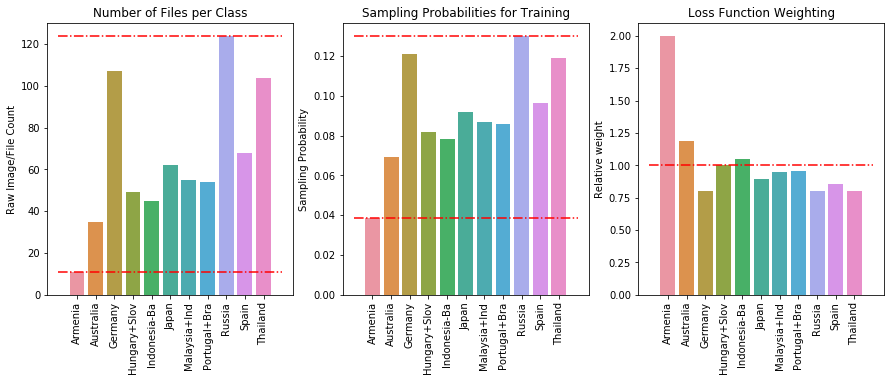

In [58]:
fig = all_train_info.display_rel_counts()
fig.savefig('imgs/rel_counts_probs_wgts.png')

all_counts = all_train_info.country_counts
max_idx = np.argmax(all_counts)
min_idx = np.argmin(all_counts)
max_name = all_train_info.country_names[max_idx]
min_name = all_train_info.country_names[min_idx]
ratio_counts =  all_train_info.country_counts[max_idx] / float(all_train_info.country_counts[min_idx])
ratio_sample =  all_train_info.sampling_probs[max_idx] / all_train_info.sampling_probs[min_idx]
print('')
print(f'{max_name} has {ratio_counts:.1f}x as many images as {min_name}')
print(f'Reduced to  {ratio_sample:.1f}x by using sqrt(N) for sampling rates')
print(f'This effectively undersamples the countries with high counts, oversamples low counts')
print(f'Further, we will multiple gradients by a weighting factor, higher for smaller counts')
print('')

In [9]:
train_spl = all_train_info.traintest_splits[0]['train']
test_spl  = all_train_info.traintest_splits[0]['test']

print('Training data:')
for country, fn_list in train_spl.items():
    n_total = all_train_info.country_counts[all_train_info.country_names.index(country)]
    print(f'   Samples from country {country.ljust(30)}: {len(fn_list)} / {n_total}')
    
print('\nTesting data:')
for country, fn_list in test_spl.items():
    n_total = all_train_info.country_counts[all_train_info.country_names.index(country)]
    print(f'   Samples from country {country.ljust(30)}: {len(fn_list)} / {n_total}')
    
country = all_train_info.country_names[0]
print(f'\nSample entries for {country}')
for fn in all_train_info.filename_map[country][:3]:
    print('  ', fn)
print('  ', '...')


Training data:
   Samples from country Australia                     : 28 / 35
   Samples from country Thailand                      : 83 / 104
   Samples from country Indonesia-Bali                : 36 / 45
   Samples from country Portugal+Brazil               : 43 / 54
   Samples from country Germany                       : 85 / 107
   Samples from country Malaysia+Indonesia            : 44 / 55
   Samples from country Spain                         : 54 / 68
   Samples from country Russia                        : 99 / 124
   Samples from country Hungary+Slovakia+Croatia      : 39 / 49
   Samples from country Japan                         : 49 / 62
   Samples from country Armenia                       : 8 / 11

Testing data:
   Samples from country Australia                     : 7 / 35
   Samples from country Thailand                      : 21 / 104
   Samples from country Indonesia-Bali                : 9 / 45
   Samples from country Portugal+Brazil               : 11 / 54
   Sample

In [12]:
for i in range(5):
    train_spl = all_train_info.traintest_splits[i]['train']
    test_spl  = all_train_info.traintest_splits[i]['test']
    print(f'Split index {i} for Spain has {len(train_spl["Spain"])} training samples {len(test_spl["Spain"])} testing samples')
        

Split index 0 for Spain has 54 training samples 14 testing samples
Split index 1 for Spain has 54 training samples 14 testing samples
Split index 2 for Spain has 54 training samples 14 testing samples
Split index 3 for Spain has 55 training samples 13 testing samples
Split index 4 for Spain has 55 training samples 13 testing samples


In [14]:
c_names = all_train_info.country_names
s_probs = all_train_info.sampling_probs
print('Here is an example batch of 100 images, sampled using sqrt(N) probs:')
c_counts = Counter([all_train_info.sample_country() for i in range(100)])
for ct, country in sorted([(ct,country) for country,ct in c_counts.items()]):
        print(f'  {ct}  samples for country {country}')

Here is an example batch of 100 images, sampled using sqrt(N) probs:
  2  samples for country Armenia
  5  samples for country Portugal+Brazil
  7  samples for country Spain
  8  samples for country Hungary+Slovakia+Croatia
  9  samples for country Australia
  9  samples for country Indonesia-Bali
  9  samples for country Thailand
  10  samples for country Japan
  10  samples for country Malaysia+Indonesia
  13  samples for country Germany
  18  samples for country Russia


In [17]:
# Test triplet sampling
for i in range(1000):
    three_files = all_train_info.sample_triplet_filenames('train')
    c_anchor, c_pos, c_neg = [f.split('/')[1] for f in three_files] # extract country names
    assert c_anchor == c_pos
    assert c_anchor != c_neg
else:
    print('Triplet sampling seems to work')
    

Triplet sampling seems to work


## Image Loading and Augmentation Utilties
We need to ensure a consistent loading and preprocessing of images, as well as mechanisms to augment them.  This will be used in a generator which loads random images according to the sampling probabilities, and 

In [30]:
%%writefile image_utilities.py

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as preproc

aug_kwargs = {'row_axis': 0, 'col_axis': 1, 'channel_axis': 2}
class ImageUtilities:
    
    
    # All augmentations should be called for all images.  Must have randomness built-in
    AUGMENTATIONS = {
        'shear':   lambda img: preproc.random_shear(img, 0.1, fill_mode='reflect', **aug_kwargs),
        'zoom':    lambda img: preproc.random_zoom(img, (0.9, 1.1), fill_mode='reflect', **aug_kwargs),
        'rotate':  lambda img: preproc.random_rotation(img, 12, fill_mode='reflect', **aug_kwargs),
        'channel': lambda img: preproc.random_channel_shift(img, 0.25, channel_axis=2),
        'hflip':   lambda img: np.flip(img, axis=1) if np.random.choice([True, False]) else img,
        'crop':    lambda img: ImageUtilities.random_crop(img)
    }
    
    @staticmethod
    def load_image(fullpath, preproc_func=lambda x: x / 255.):
        """
        This loads and image from file, doing a couple of basic checks before
        """
        out = preproc.img_to_array(preproc.load_img(fullpath))
        out = preproc_func(out)
        
        # All training images were resized down to smaller versions before training...
        if max(out.shape[:2]) > 512:
            ref_size = max(out.shape[:2])
            scale = float(512) / ref_size
            new_sz0 = int(scale * out.shape[0])
            new_sz1 = int(scale * out.shape[1])
            out = cv2.resize(out, (new_sz1, new_sz0))
            
        return out.astype('float32')
    
    @staticmethod
    def rotate_image_90deg(img, clicks):
        """
        Rotate image in multiples of 90 deg. `clicks` is the number of multiples.
        """
        if clicks == 0:
            return img
        if clicks in [1, -3]:
            return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        elif clicks in [2, -2]:
            return cv2.rotate(img, cv2.ROTATE_180)
        elif clicks in [3, -1]:
            return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            raise Exception(f'Invalid click count for rotation (0-3): {clicks}')
            
            
    @staticmethod
    def random_crop(img):
        # Randomly choose to crop the image, and if crop, randomly choose crop size and shift
        h,w = img.shape[:2]
        
        # 1/3 chance we do no cropping (if not already square)
        if h == w or np.random.choice([True, False], p=[0.33, 0.67]):
            return img
        
        if h > w:
            new_h = np.random.choice(range(w, h)) # random new height between full and square
            max_offset = h - new_h
            offset = np.random.choice(range(max_offset)) # random offset from top of image
            return img[offset:offset+new_h, :, :]
        else:
            new_w = np.random.choice(range(h, w)) # random new width between full and square
            max_offset = w - new_w
            offset = np.random.choice(range(max_offset)) # random offset from left of image
            return img[:, offset:offset+new_w, :]
            
            
    @staticmethod
    def augment_image(img, resize_to=None):
        """
        Apply all augmentations to each image, but in a randomized order
        """
        aug_keys = list(ImageUtilities.AUGMENTATIONS.keys())
        np.random.shuffle(aug_keys)
        
        out = img
        for aug_name in aug_keys:
            out = ImageUtilities.AUGMENTATIONS[aug_name](out)
            
        if resize_to:
            out = cv2.resize(out, resize_to)
        
        return out



Overwriting image_utilities.py


In [31]:
from image_utilities import *

Display 3 samples of each augmentation in isolation


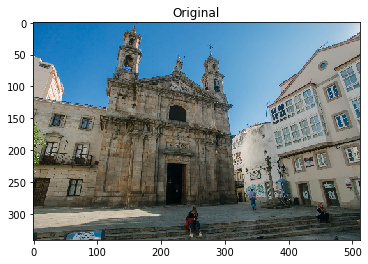

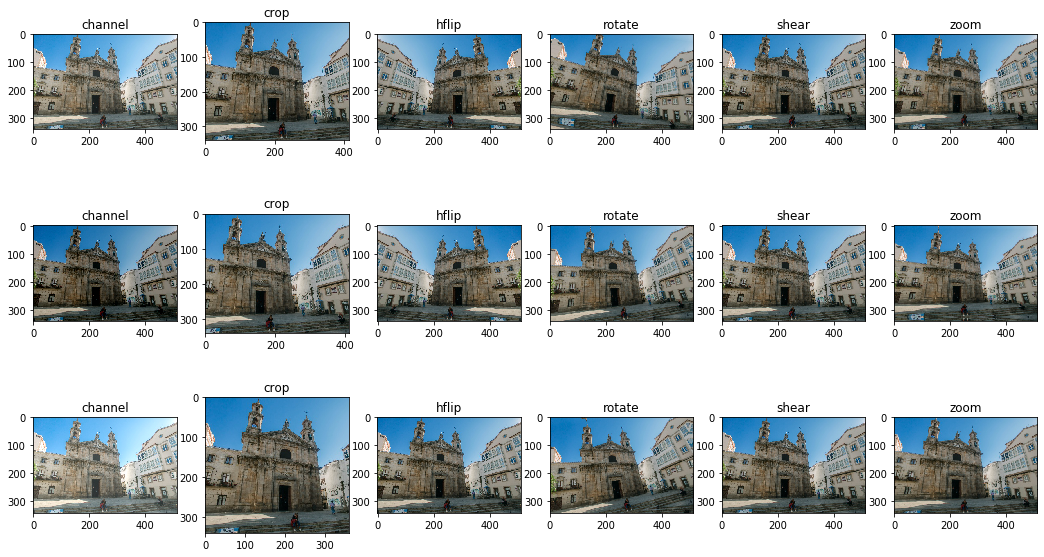

In [47]:
country = 'Spain'
rand_file = np.random.choice(all_train_info.filename_map[country])
img = ImageUtilities.load_image(rand_file)
plt.imshow(img)
plt.title('Original')
augs = ImageUtilities.AUGMENTATIONS
augtypes = sorted(augs.keys())
fig,axs = plt.subplots(3, len(augtypes), figsize=(18,10))
print('Display 3 samples of each augmentation in isolation')
for r in range(3):
    for c in range(len(augtypes)):
        aug_str = augtypes[c]
        axs[r][c].imshow(augs[aug_str](img))
        axs[r][c].set_title(aug_str)
    


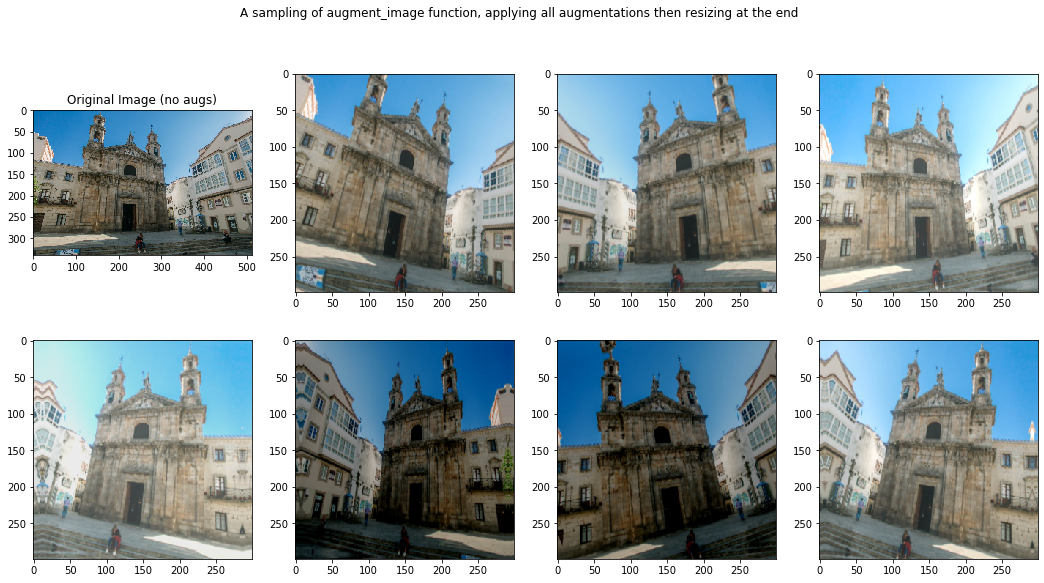

In [53]:
# Test full augmentations
fig, axs = plt.subplots(2,4, figsize=(18,9))
for r in range(2):
    for c in range(4):
        if (r,c) == (0,0):
            axs[r][r].imshow(img)
            axs[r][r].set_title('Original Image (no augs)')
        else:
            aug_img = ImageUtilities.augment_image(img, (299, 299))
            axs[r][c].imshow(aug_img)
        
_ = fig.suptitle('A sampling of augment_image function, applying all augmentations then resizing at the end')